In [209]:
import pickle
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200

In [210]:
with open("Data/data.pkl", "rb") as fp:   # Unpickling
    data_list = pickle.load(fp)
    
xpts, ypts, zpts, _, magpts = data_list

In [211]:
# check data
assert(len(xpts)==len(ypts) and len(xpts)==len(zpts) and len(xpts)==len(magpts))

In [212]:
# Transform the data into X, y form
n = len(xpts)
d = 3
X = np.array([xpts, ypts, zpts]).T
y = np.array(magpts)

In [213]:
alpha = 0.05 
kernel=Matern(nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(X[:-20], y[:-20])

# check
print("Training score:%f"%gpr.score(X[:-20], y[:-20]))
print("Test score:%f (This should be slightly less than training, otherwise decrease alpha)"%gpr.score(X[-20:], y[-20:]))
gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(X, y)

Training score:0.975102
Test score:0.959987 (This should be slightly less than training, otherwise decrease alpha)


In [214]:
gpr.predict(X[1:2])

array([102.73064864])

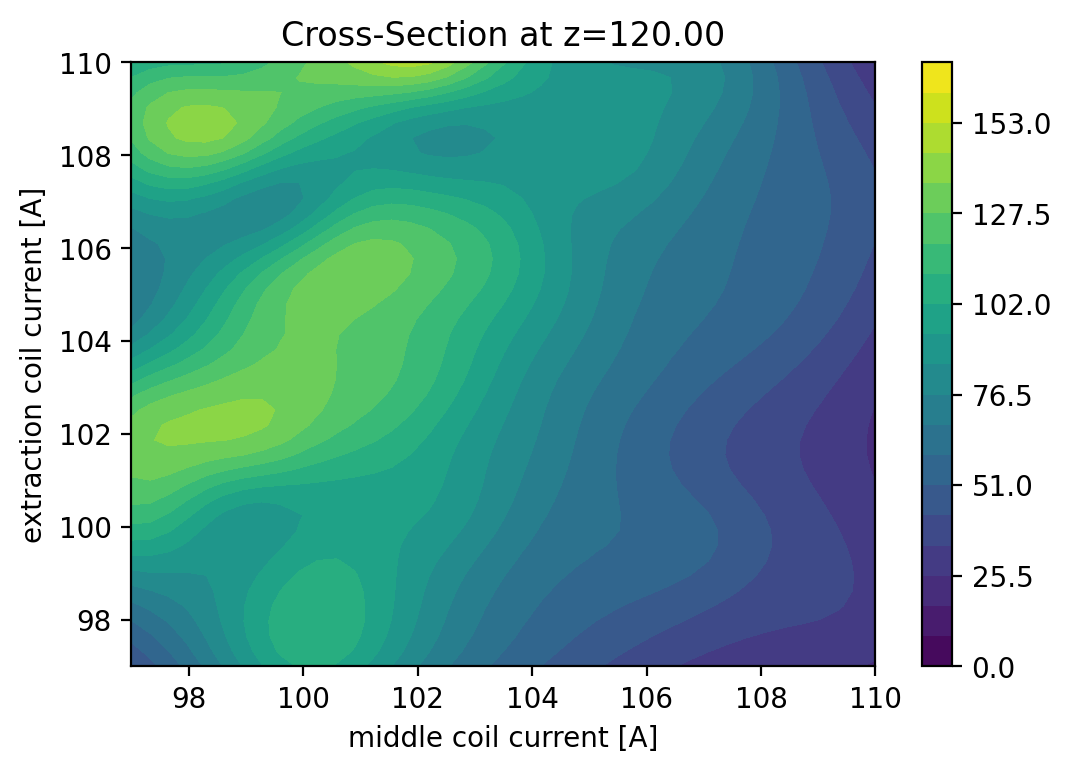

In [251]:
def plot_cross_section(gpr, z_plot):
    def gauss_mean(x, y, z=123):
        arr = np.array([[x,y,z]])
        result = gpr.predict(arr)
        return result

    n_plot = 41
    x = np.linspace(97, 110, n_plot)
    y = np.linspace(97, 110, n_plot)
    z = np.array([gauss_mean(i,j,z=z_plot) for j in y for i in x])

    X, Y = np.meshgrid(x, y)
    Z = z.reshape(n_plot, n_plot)
    # plt.contourf(X, Y, Z, vmin=20, vmax=155)
    # plt.colorbar()
    
    levels = np.linspace(0, 170,21)
    img=plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(img)
    
    
    plt.xlabel("middle coil current [A]")
    plt.ylabel("extraction coil current [A]")
    plt.title("Cross-Section at z=%.2f"%z_plot)
    plt.savefig("Figures/GPRplots/z%d.png"%int(z_plot*10))
    plt.show()
    return
plot_cross_section(gpr, 120)

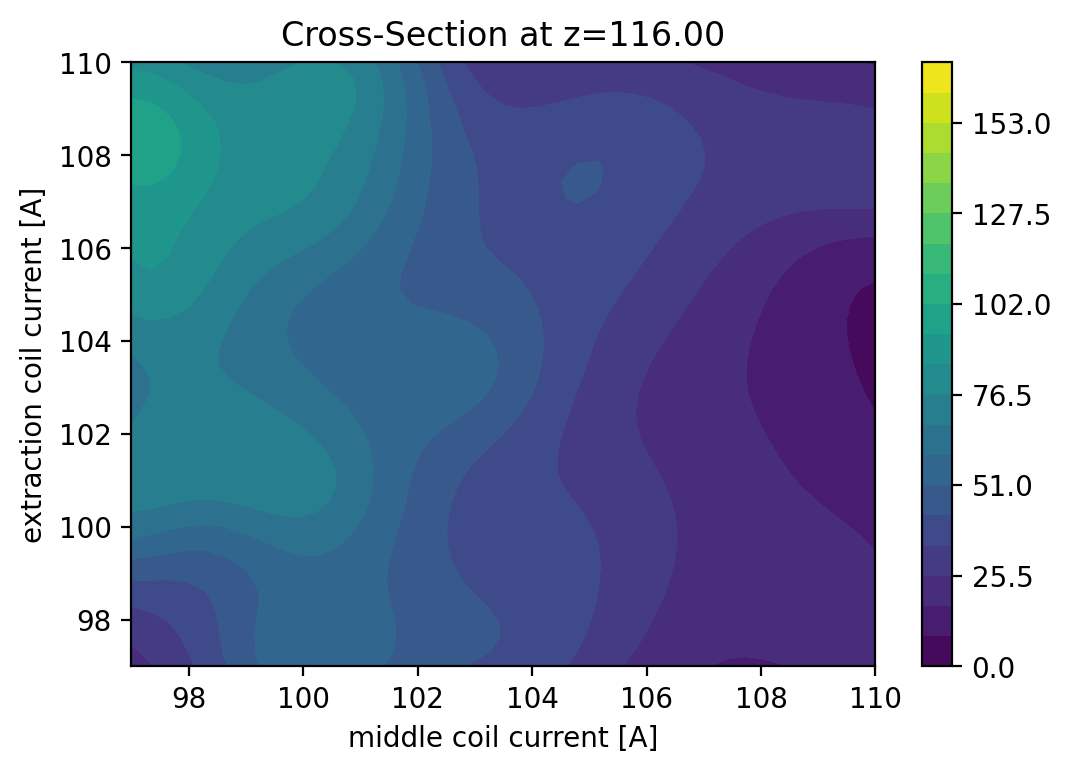

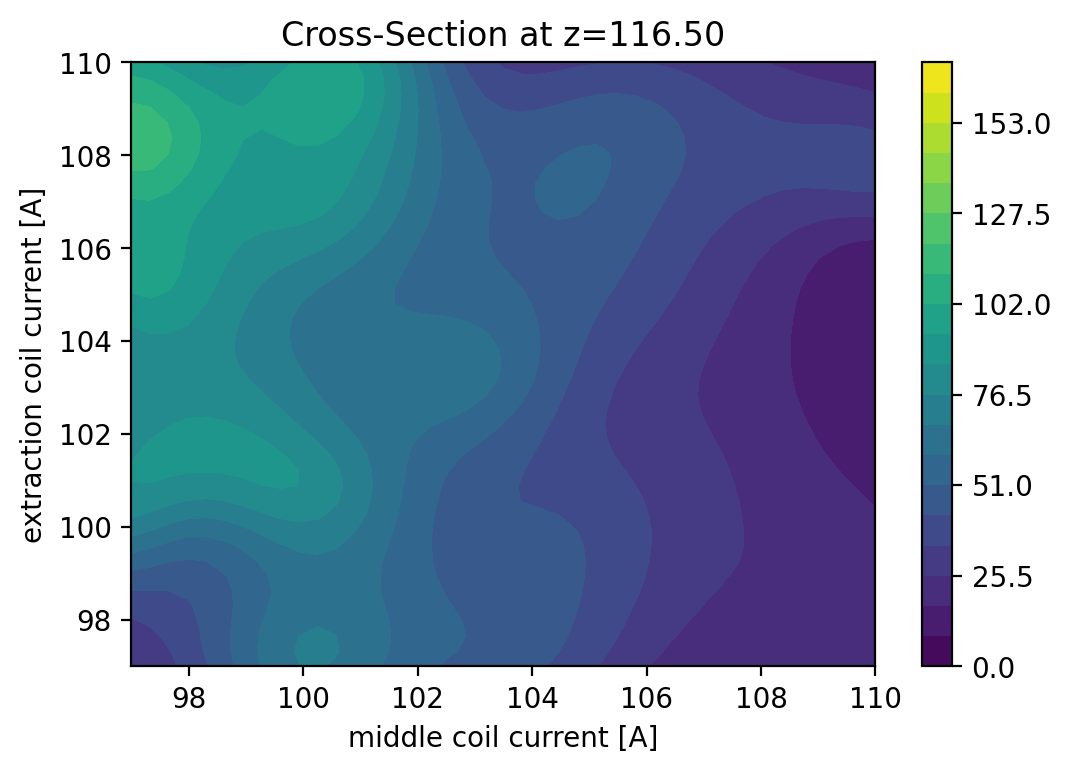

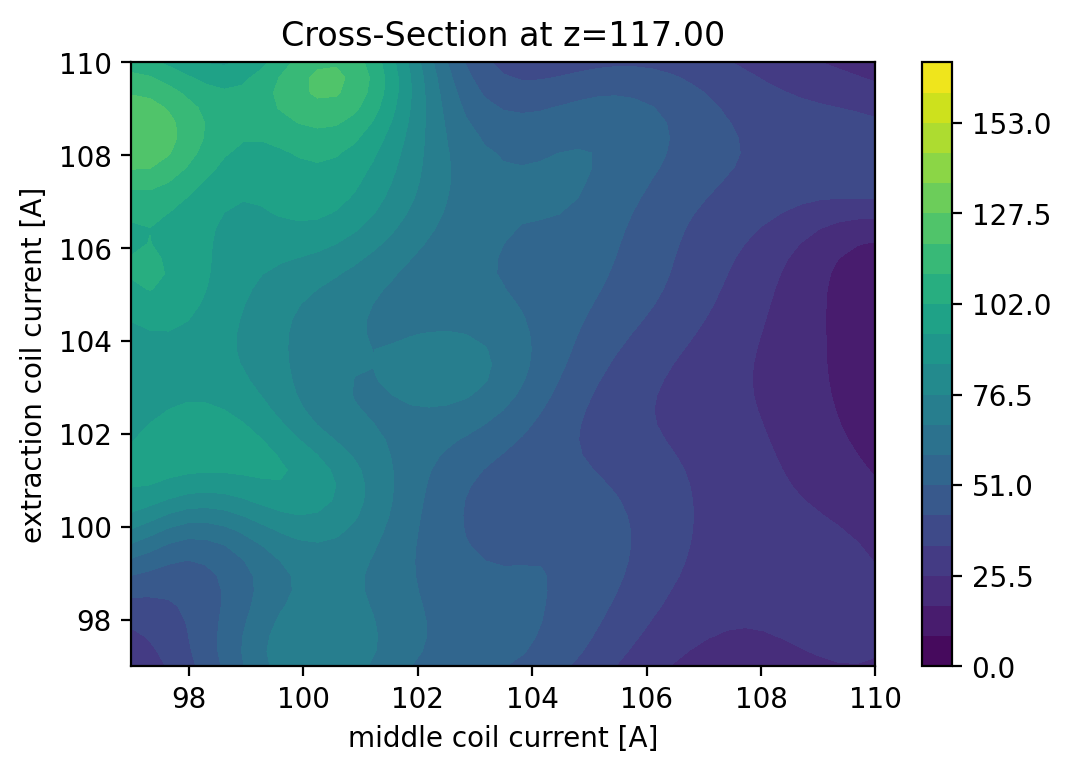

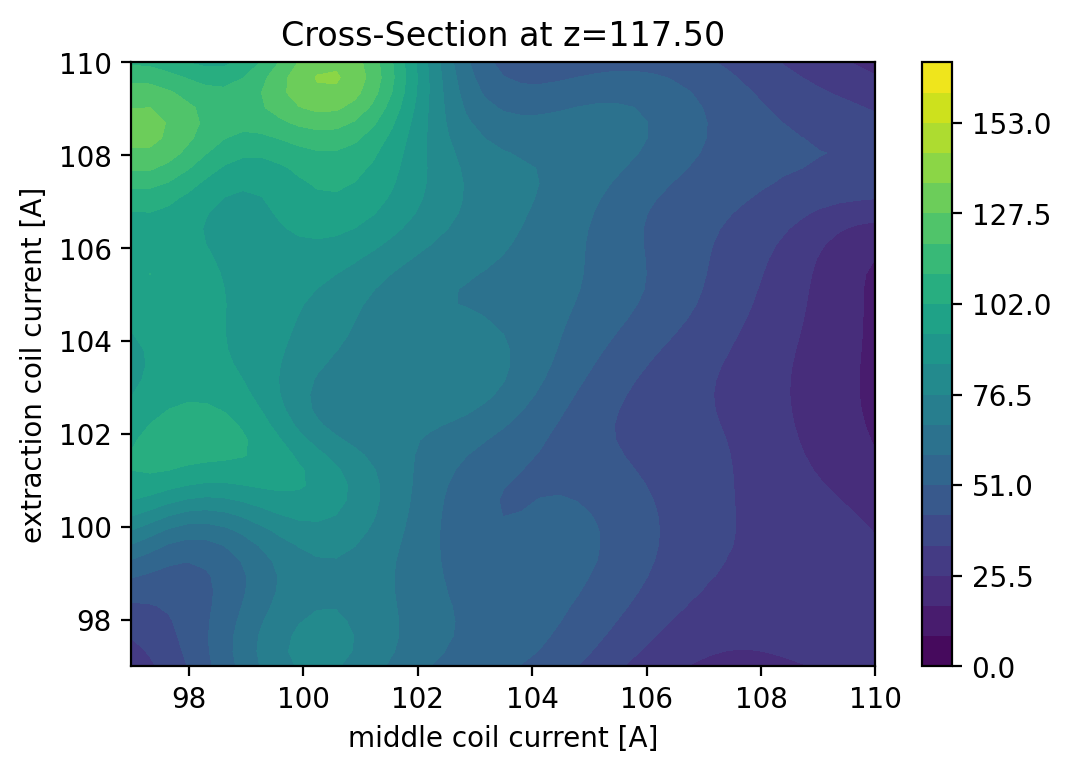

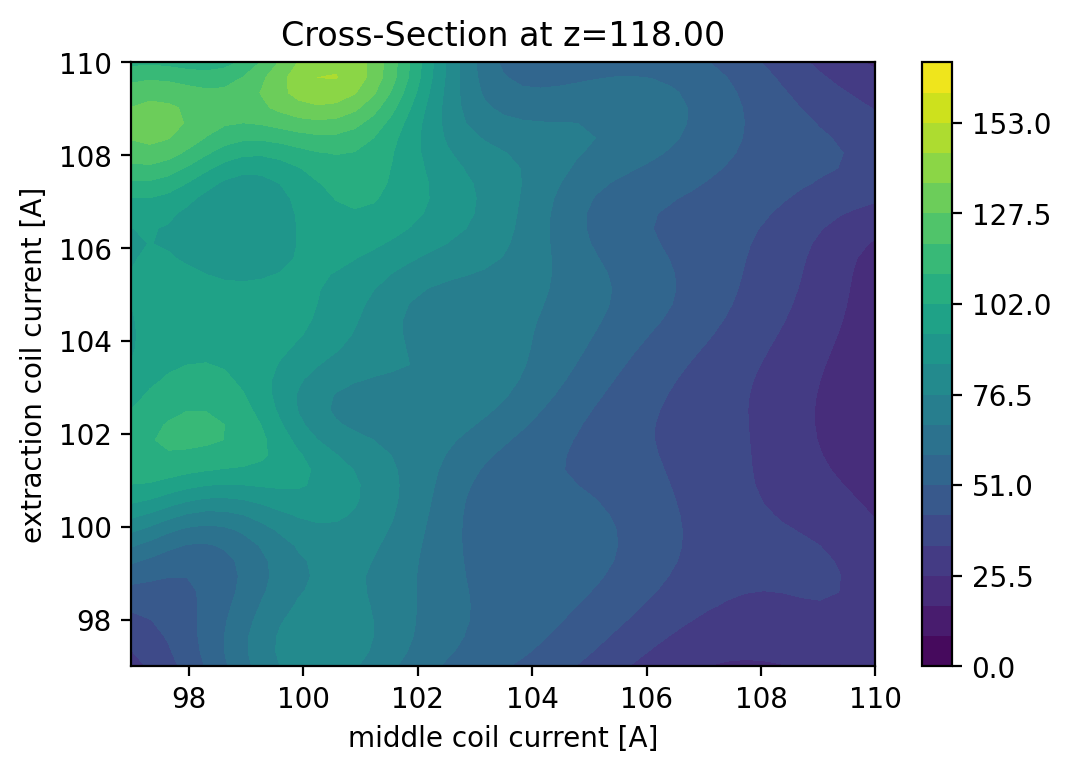

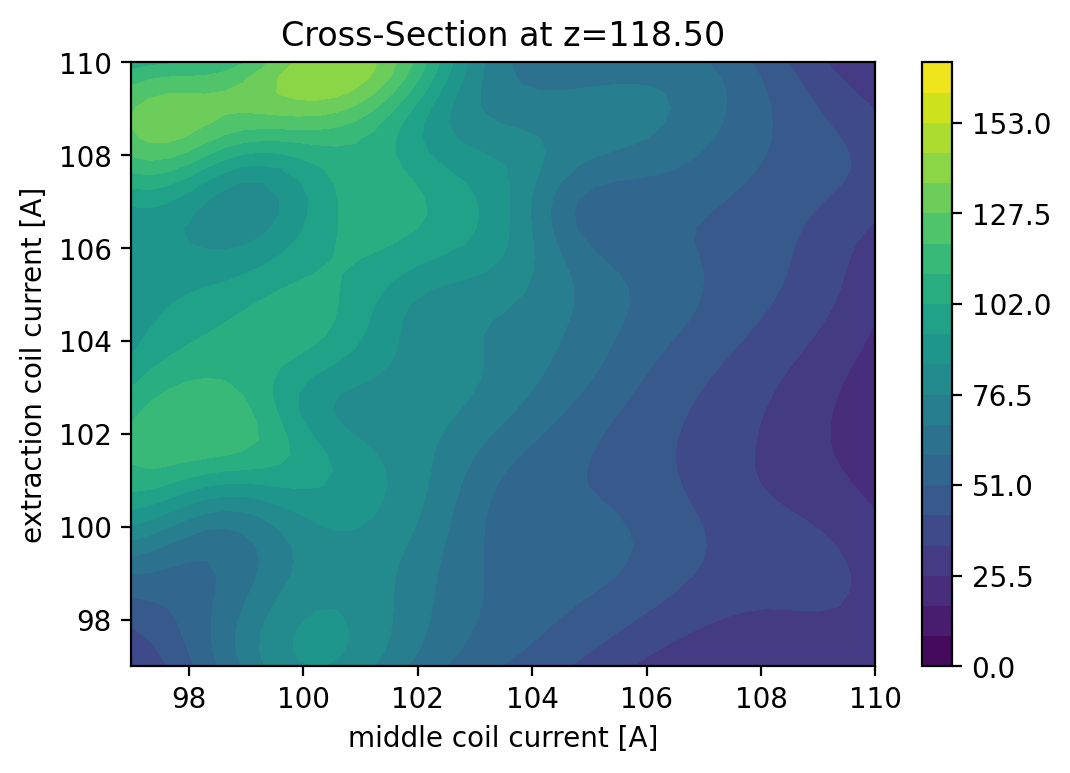

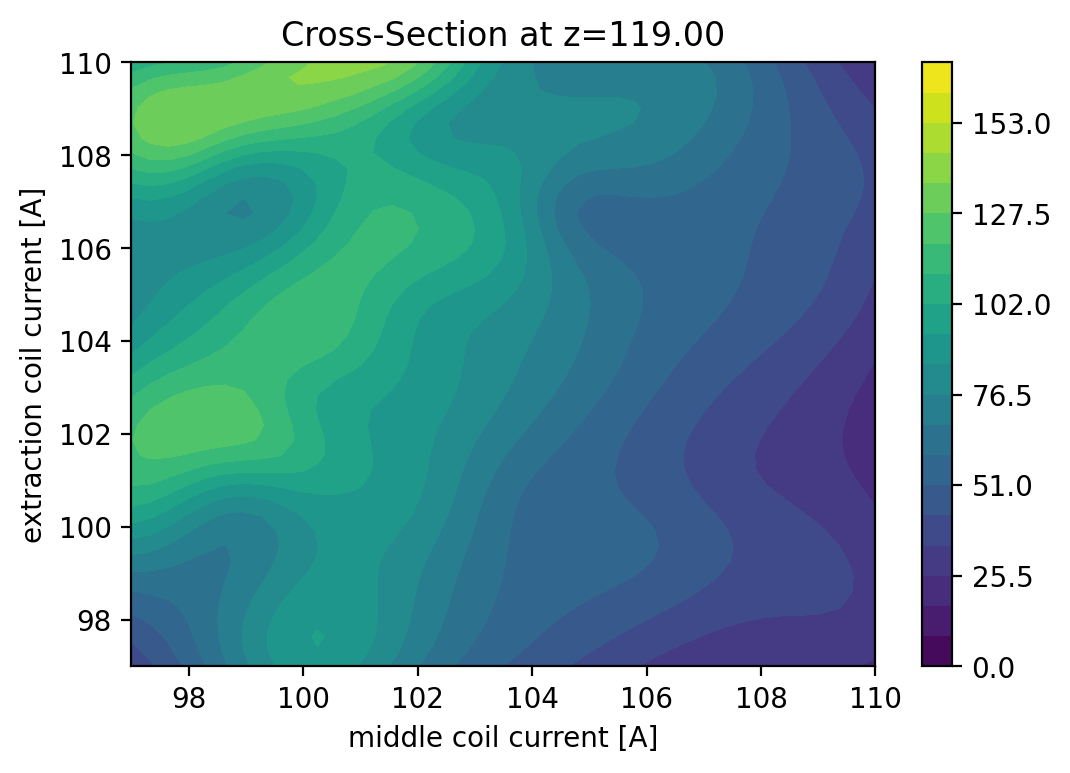

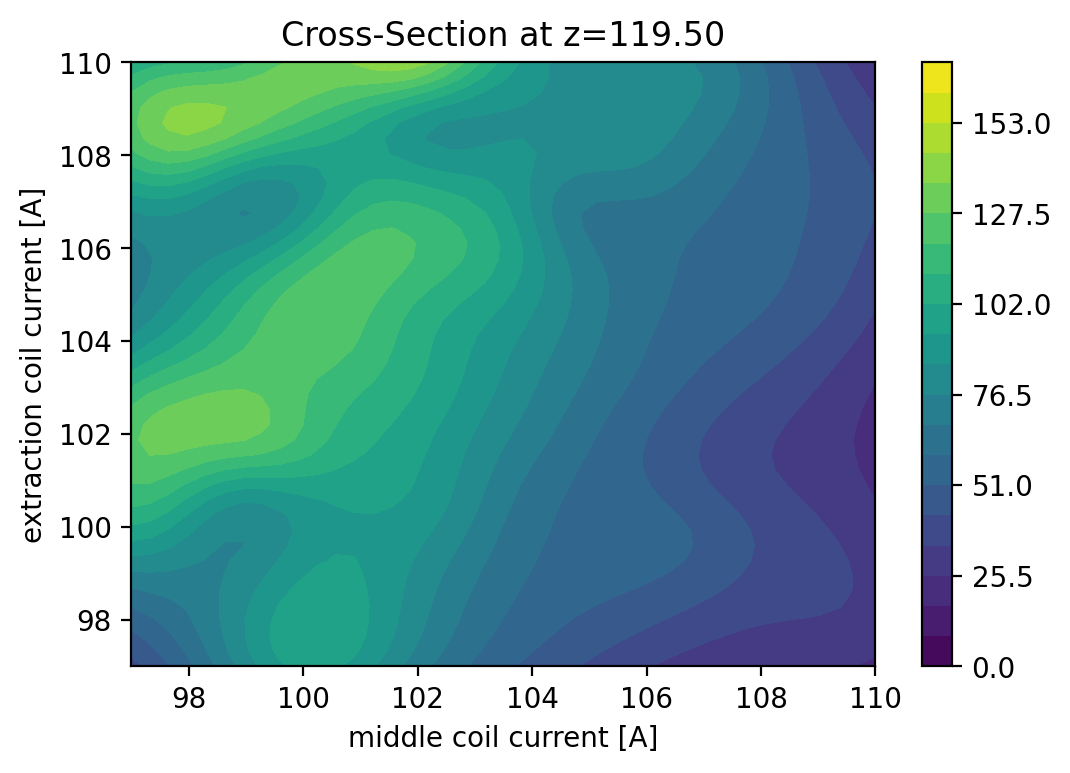

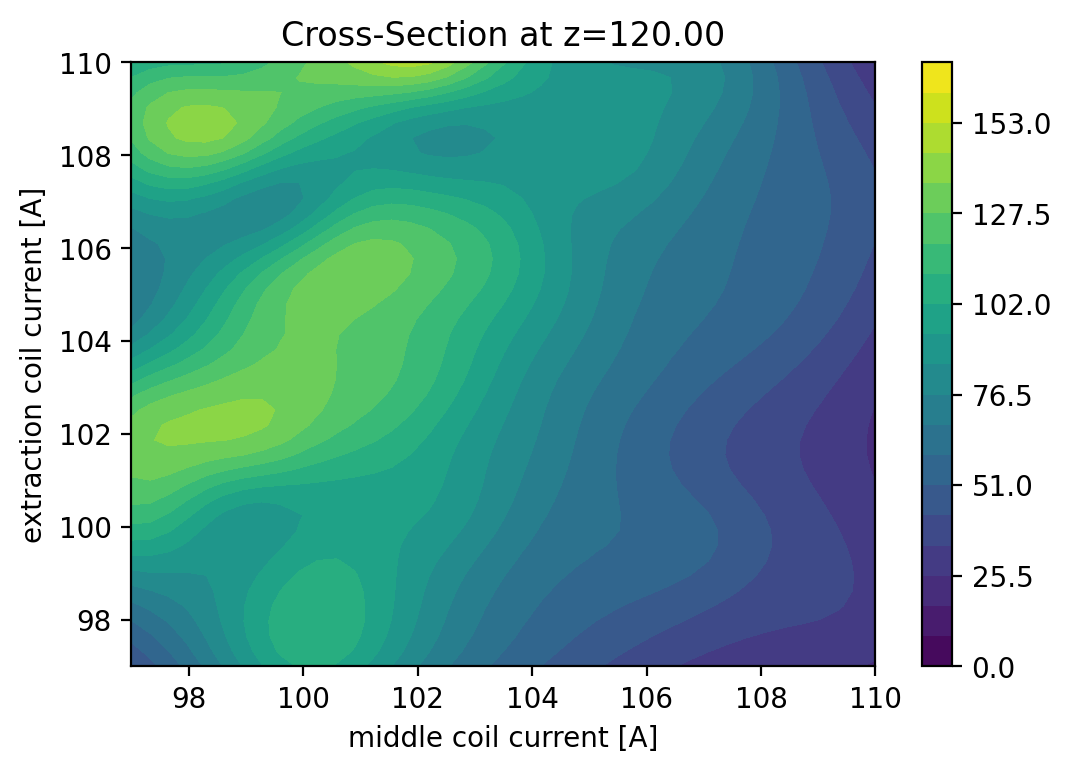

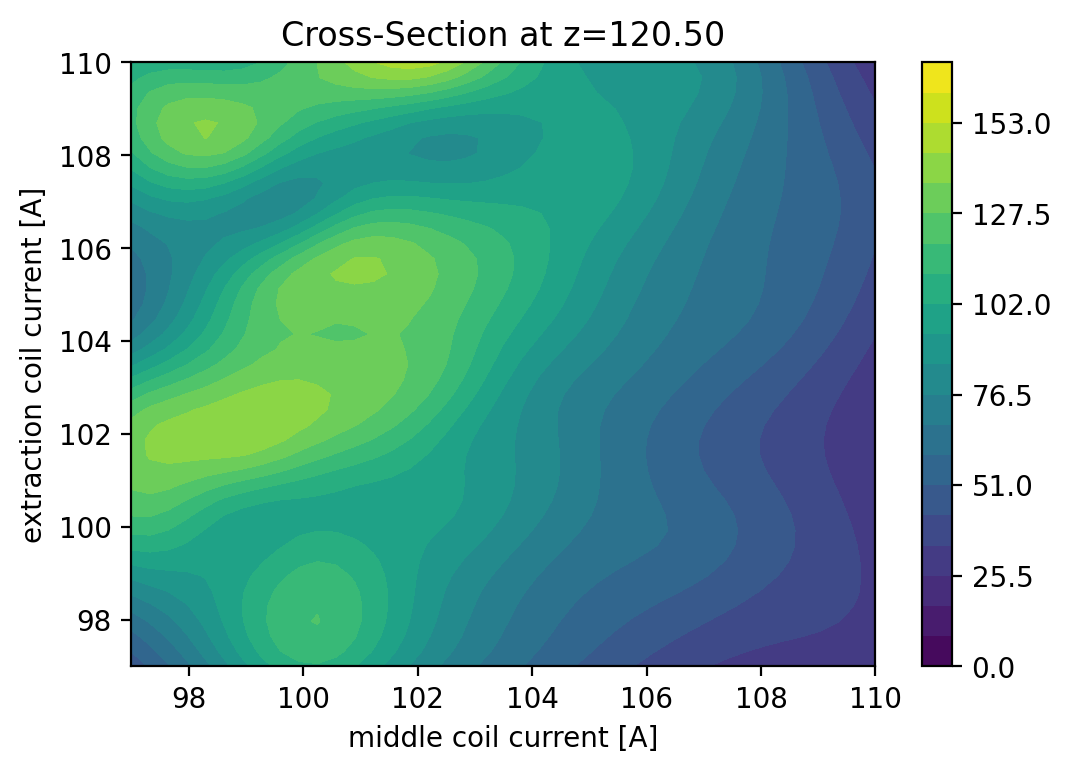

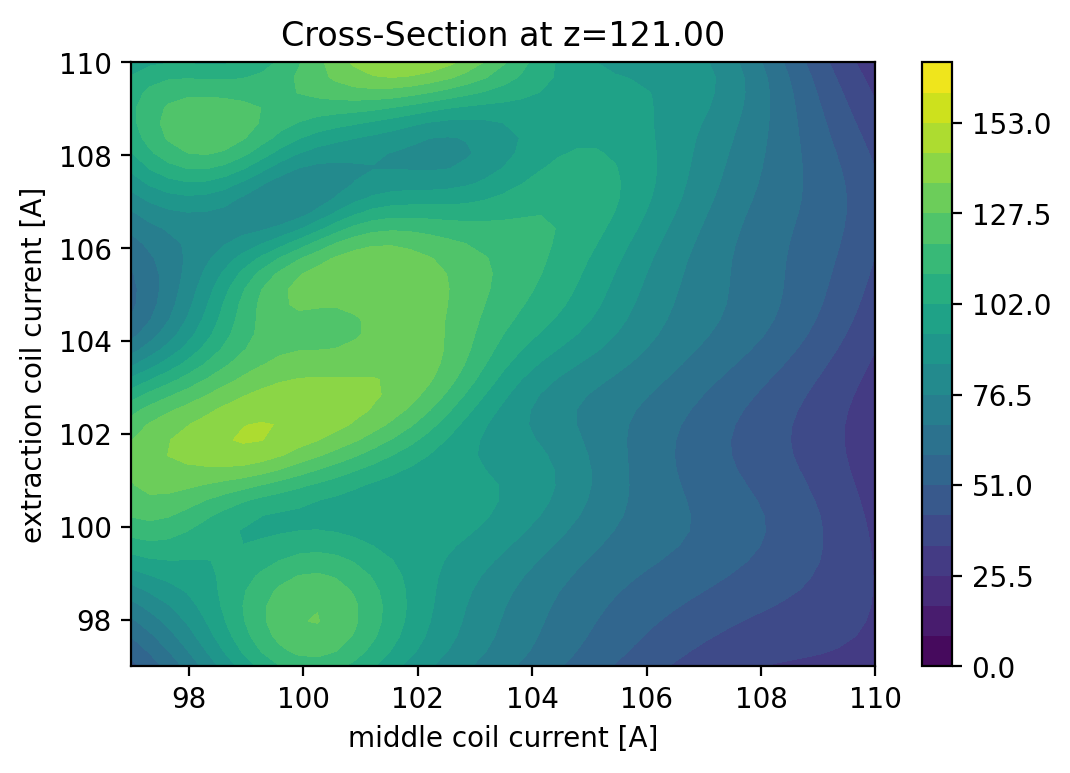

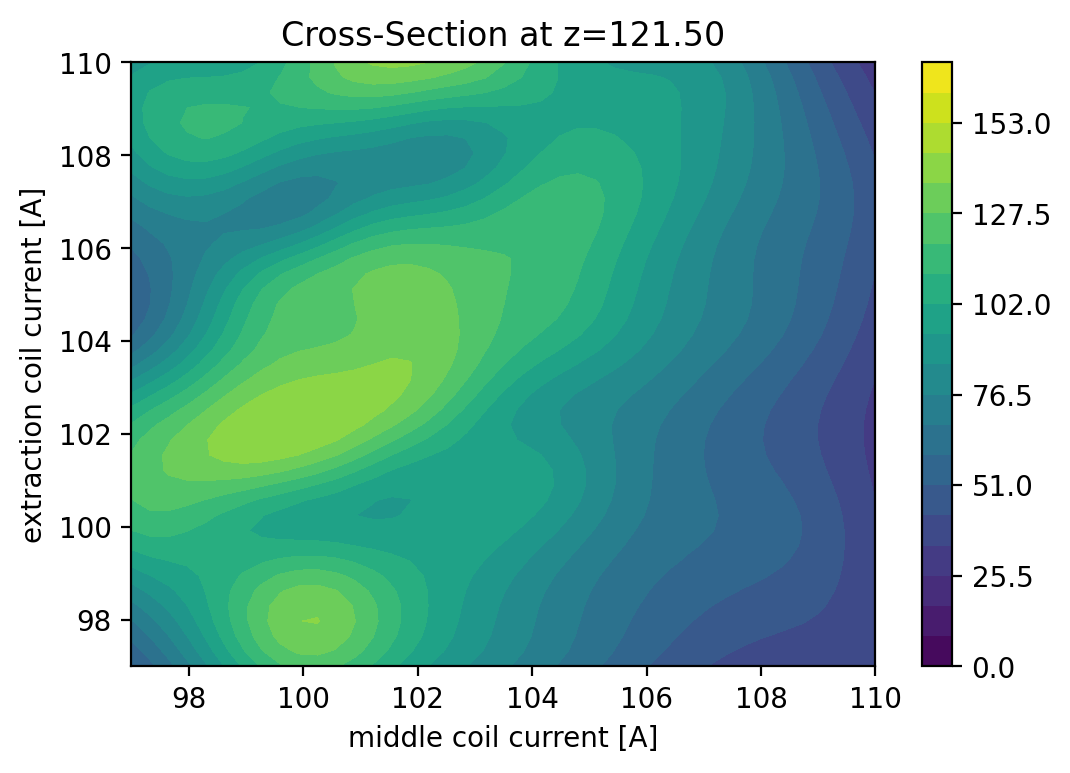

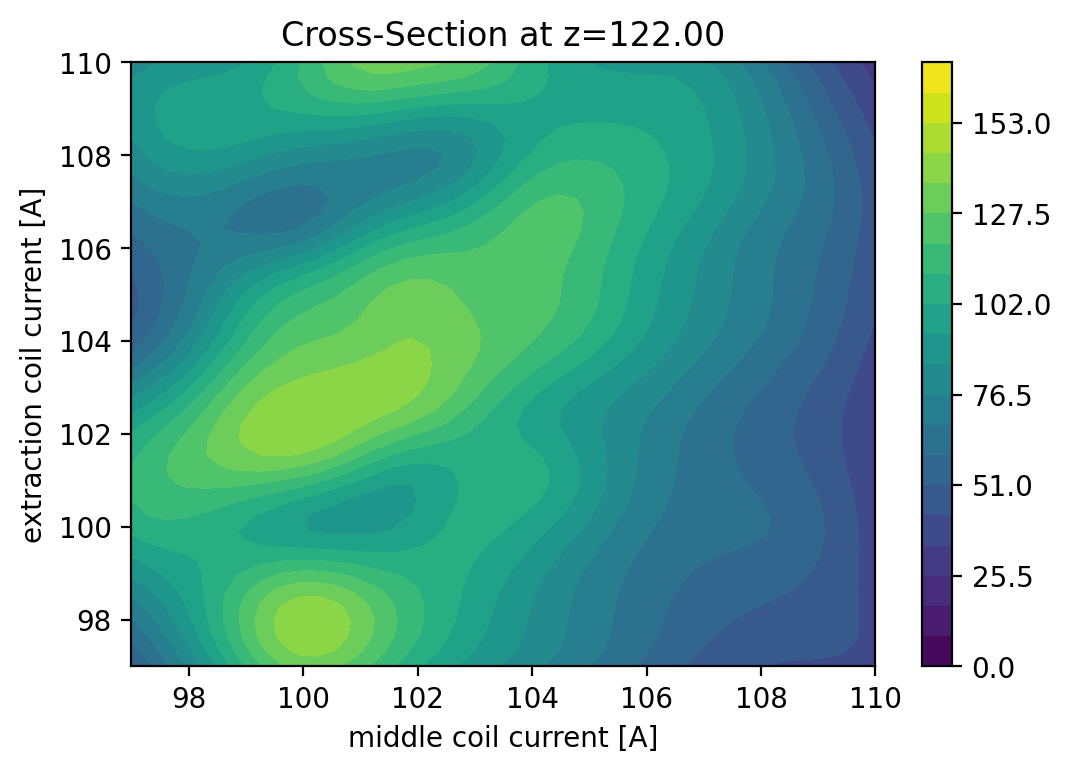

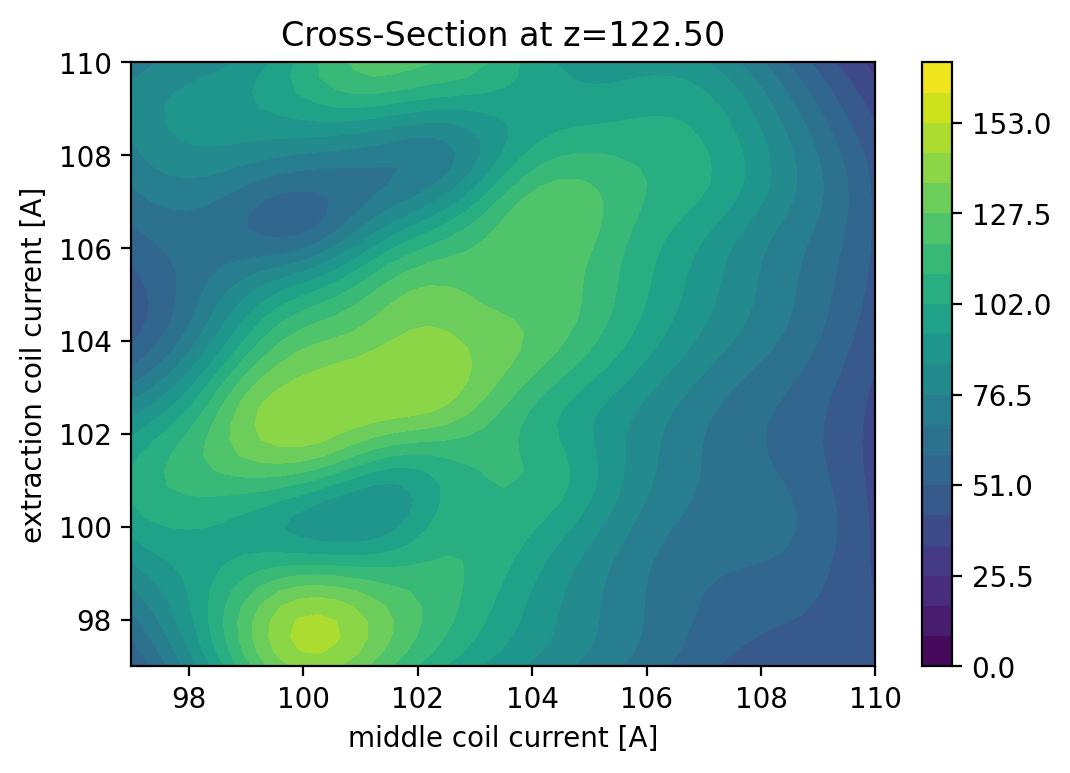

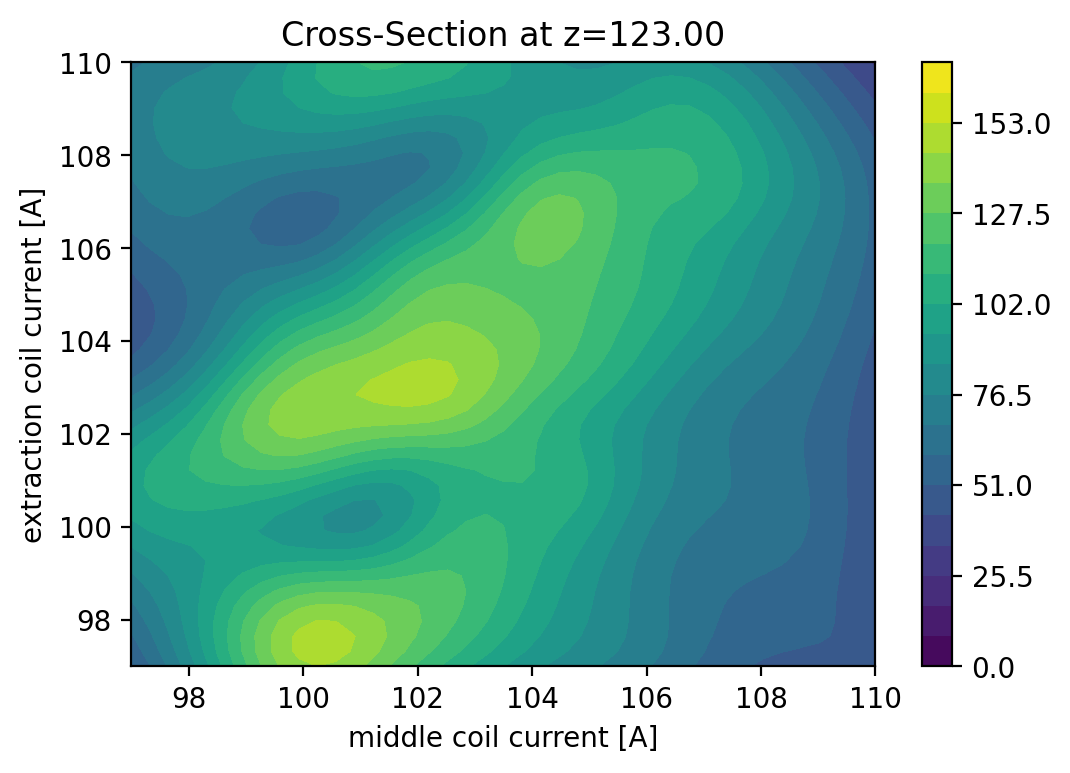

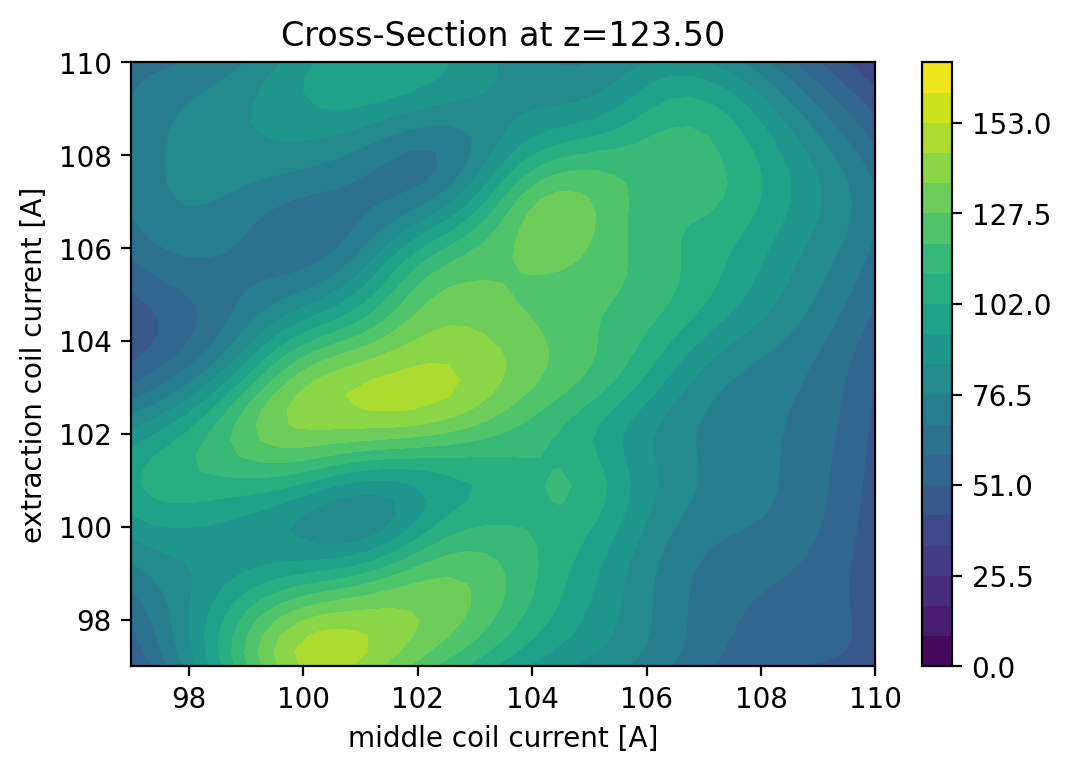

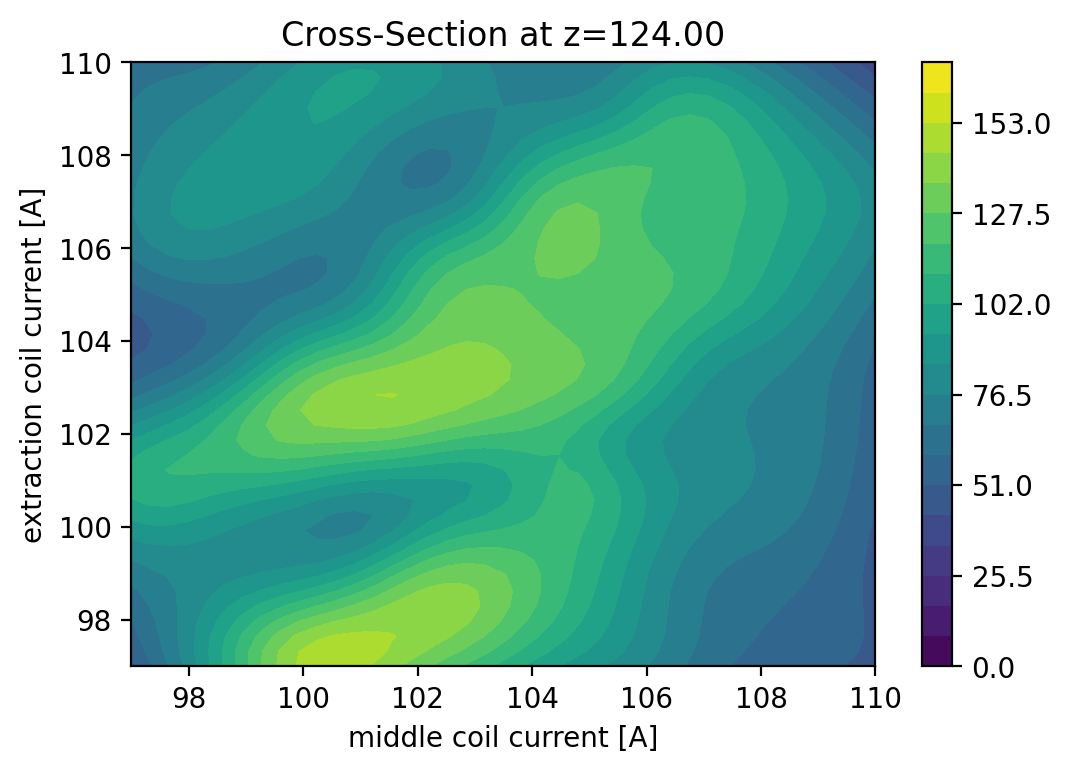

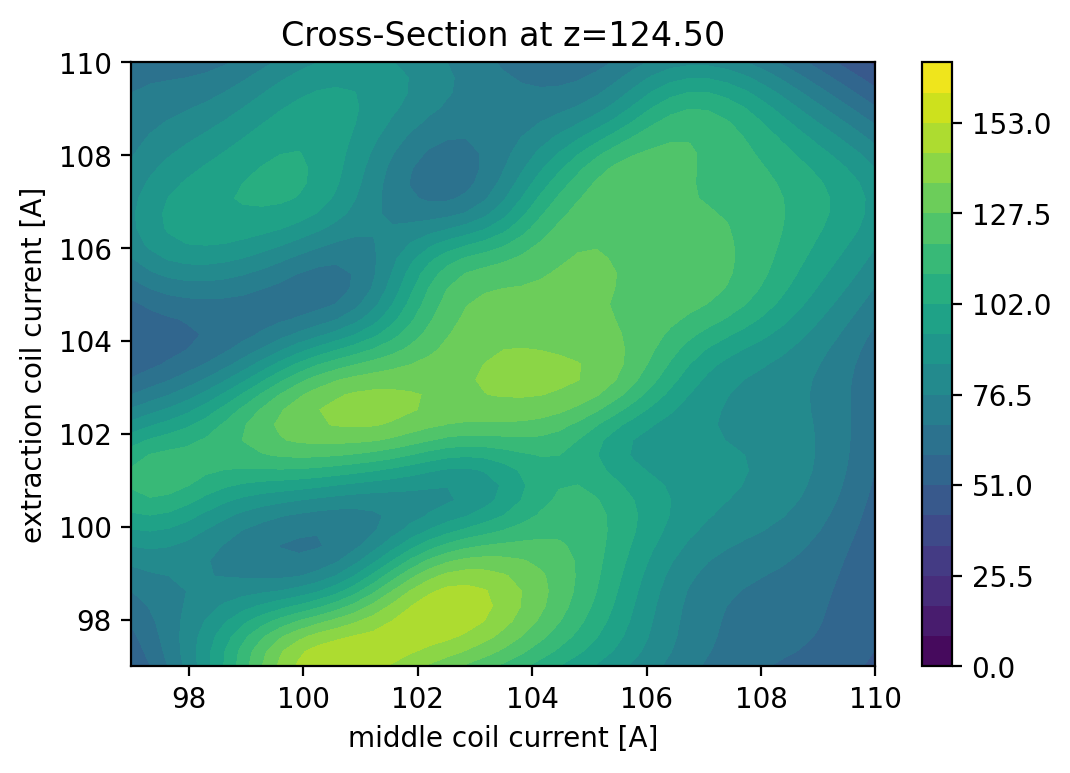

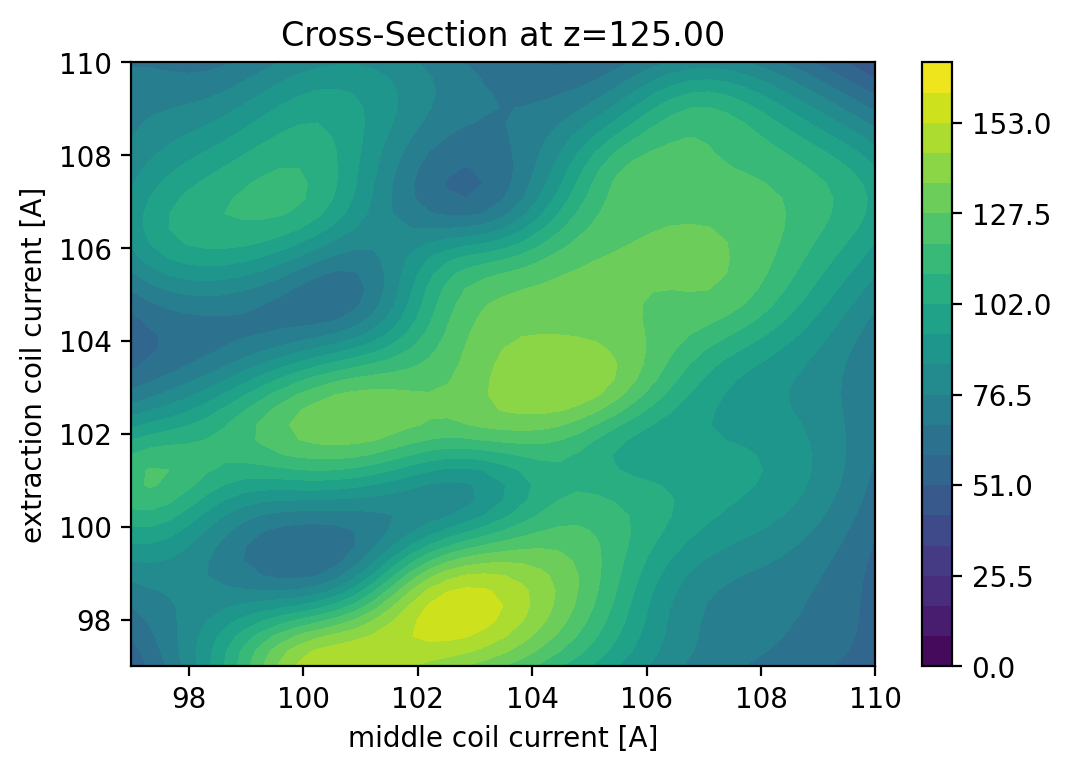

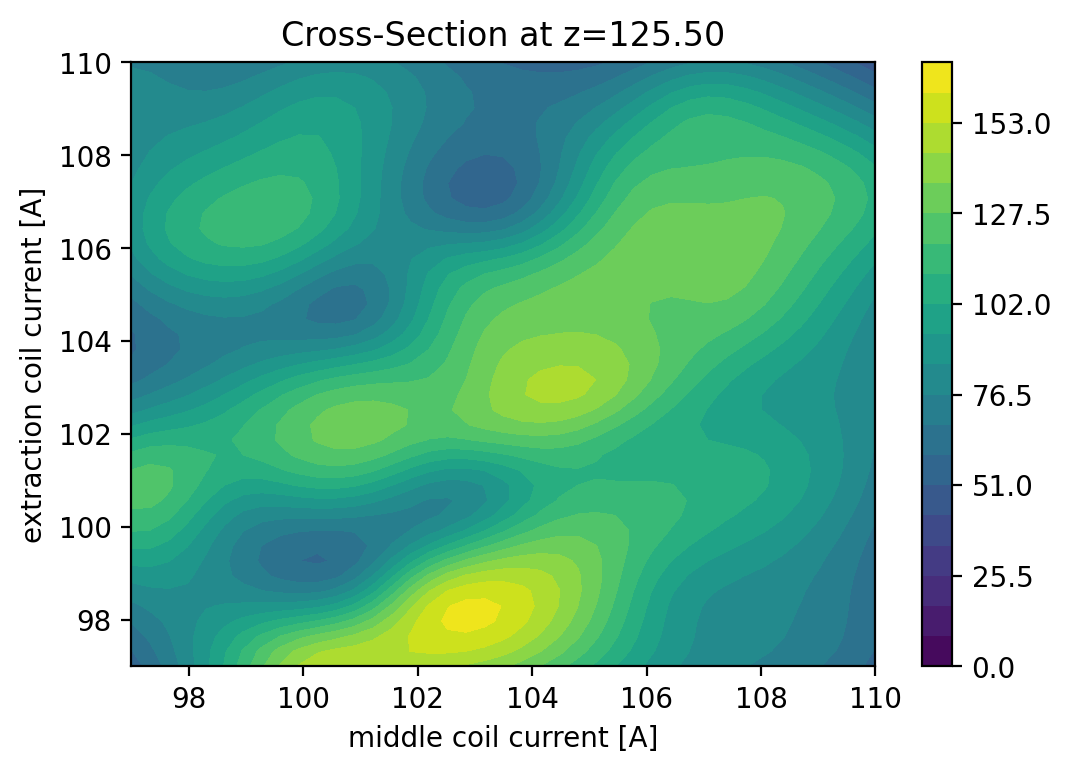

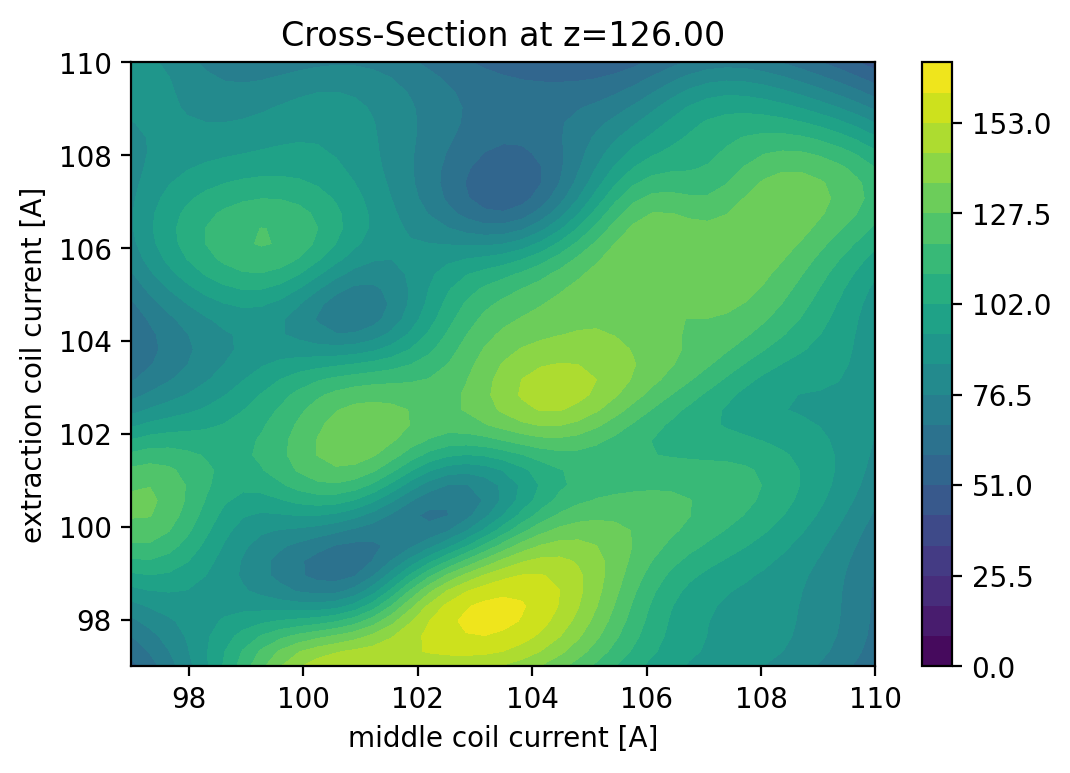

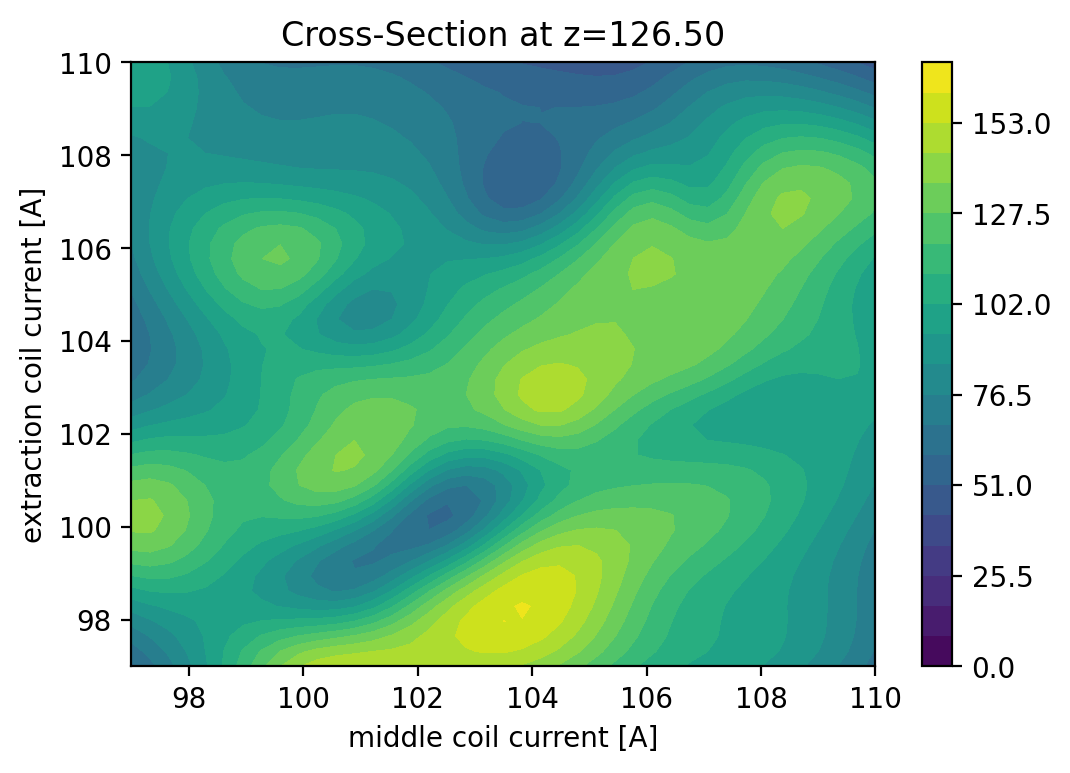

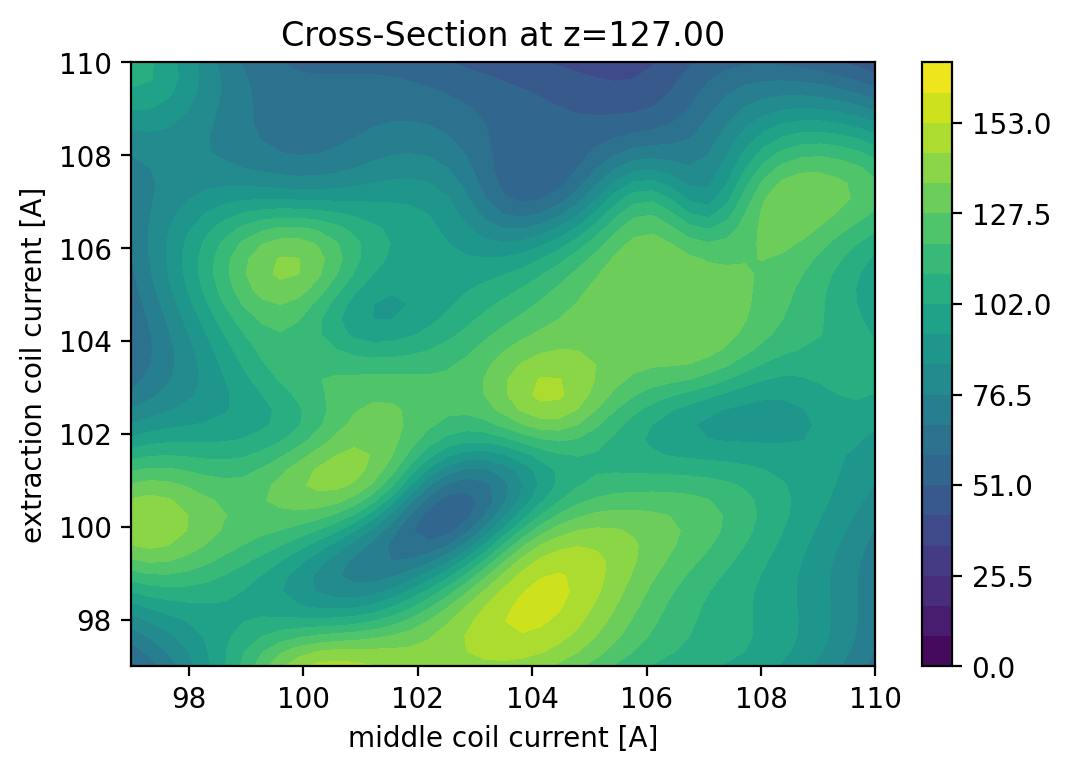

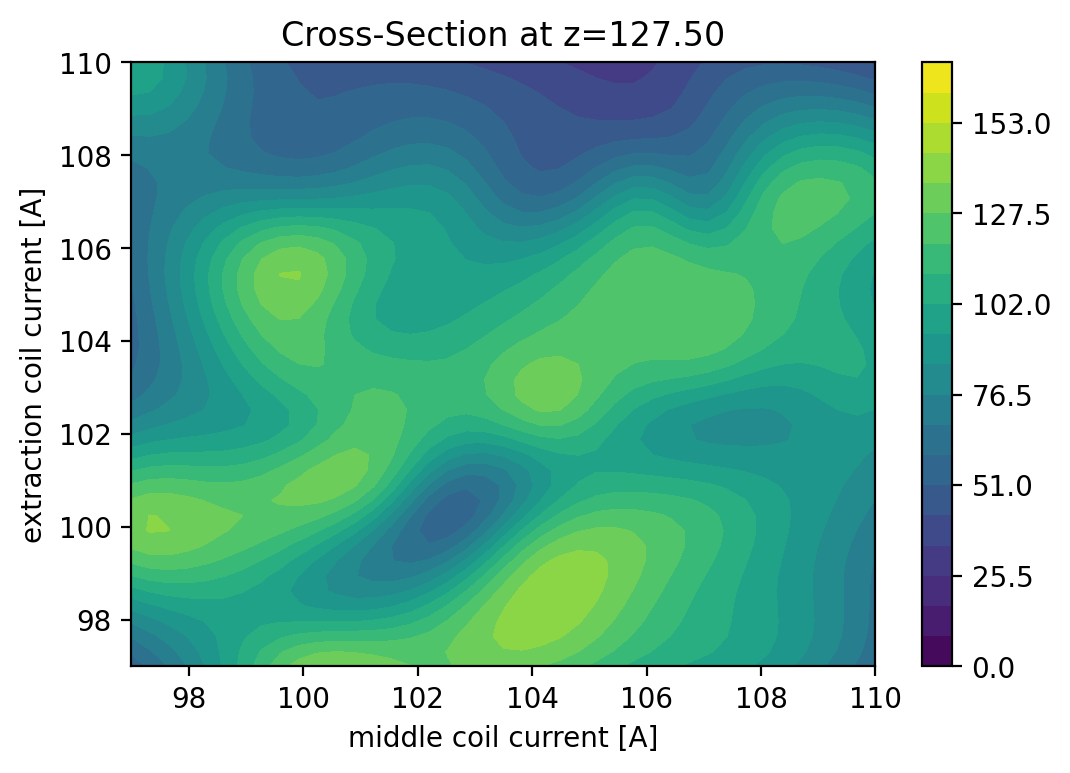

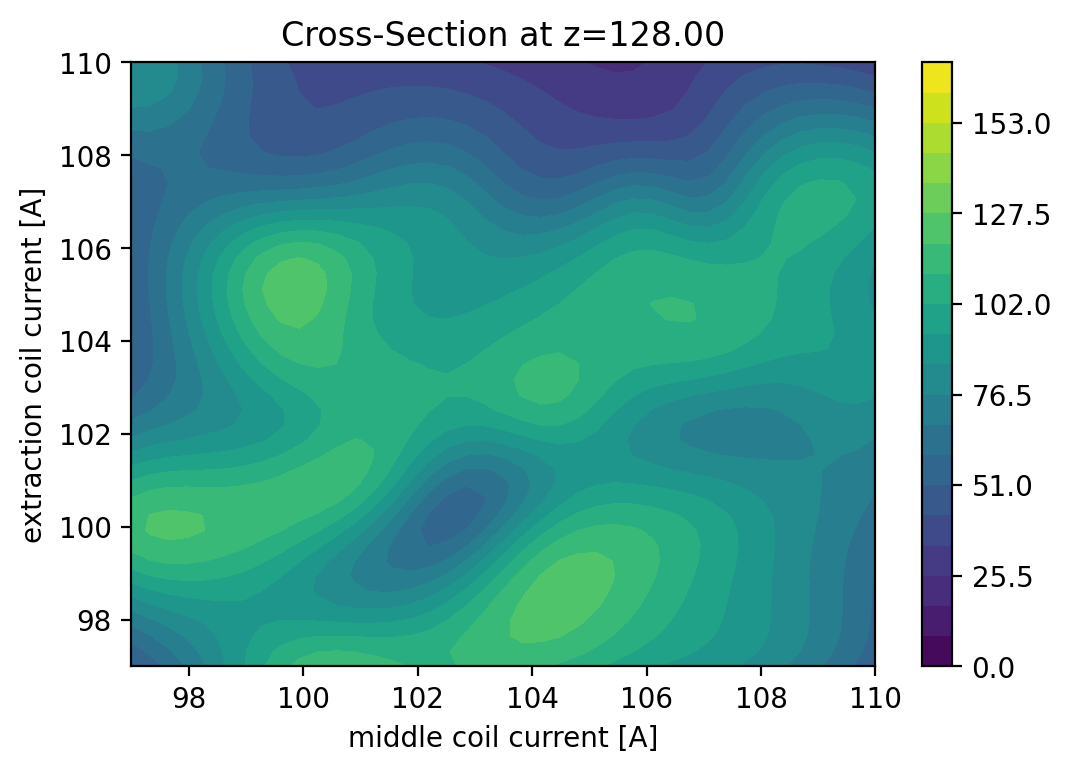

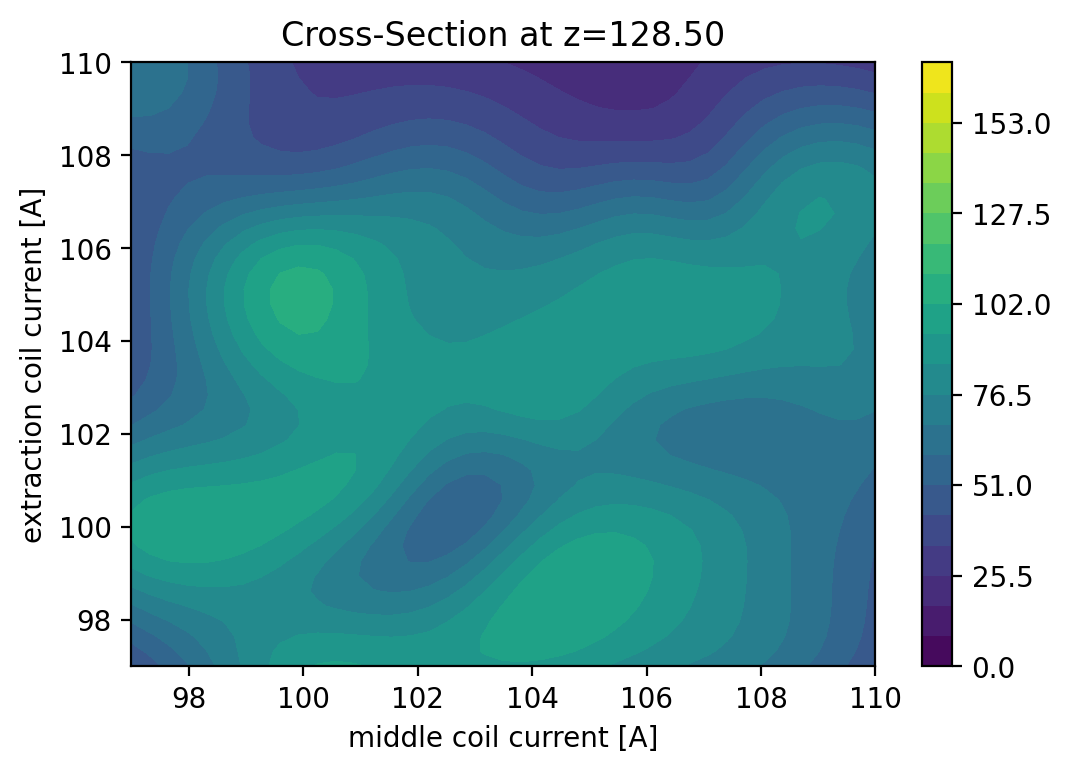

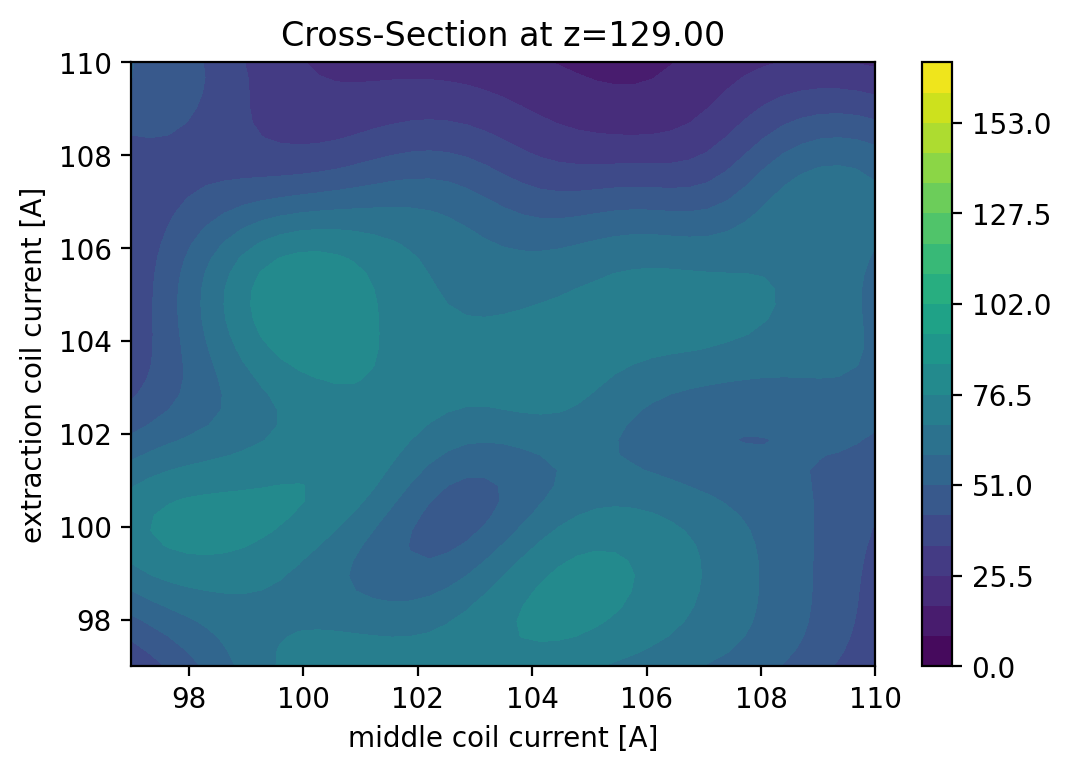

In [254]:
for z in np.linspace(116, 129, 27):
    plot_cross_section(gpr, z)